### Nama : Alisha Zahra Saadiya
### NIM : 2501971742

Case Number = 4 + 2 = 6

Case 2 : ERNIE

In [ ]:
!pip install tensorflow
!pip install nltk
!pip install transformers
!pip install contractions
!pip install tensorflow-addons

In [ ]:
import os
import torch
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import re
import contractions
from nltk.corpus import stopwords
from transformers import ErnieForSequenceClassification, BertForSequenceClassification, ErnieConfig
from transformers import ErnieModel, AutoTokenizer, TFBertModel
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, f1_score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. a.
 Perform Preprocess and prepare Dataset step, describe each step including some concepts in Natural Language Processing (NLP)

In [ ]:
data = pd.read_csv('Emotion.csv')

In [ ]:
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
data['label'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64

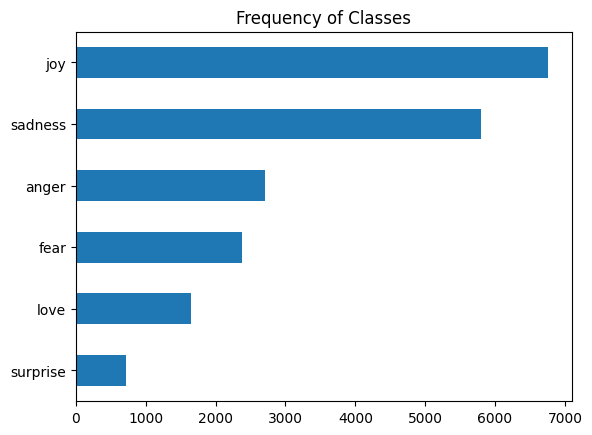

In [ ]:
data["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
data['label'] = data['label'].map({'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5})

In [ ]:
data

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1
...,...,...
19995,im having ssa examination tomorrow in the morn...,0
19996,i constantly worry about their fight against n...,5
19997,i feel its important to share this info for th...,5
19998,i truly feel that if you are passionate enough...,5


In [ ]:
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'\W', ' ', text.lower())

    # Handle contractions
    text = contractions.fix(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [ ]:
# Apply the preprocessing function to the 'text' column
data['text'] = data['text'].apply(preprocess_text)

# Remove stop words
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [ ]:
# ERNIE 2.0 tokenizer
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-base-en", truncation=True, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Natural Language Processing (NLP) merupakan bidang kecerdasan buatan (AI) yang berfokus pada interaksi antara komputer dan bahasa manusia. Bidang ini melibatkan pengembangan model komputasi dan algoritme untuk memungkinkan komputer memahami, menafsirkan, dan menghasilkan bahasa manusia dengan cara yang berharga dan bermakna. Penjelasan konsep Natural Language Processing (NLP) pada code :     
- text = re.sub(r'\W', ' ', text.lower()) -> Menghapus karakter khusus dengan menggantinya dengan spasi dan mengonversi seluruh teks menjadi huruf kecil. Dalam konsep NLP membantu untuk memperlakukan kata-kata dengan cara yang tidak peka huruf besar-kecil dan mengurangi ukuran kosakata.
- text = contractions.fix(text) -> Memperluas kontraksi dalam teks (misalnya don't diperluas menjadi do not). Dalam konsep NLP menangani kontraksi sangat penting untuk menjaga integritas kata dalam teks. Ini memastikan bahwa kata-kata terwakili dalam bentuk lengkapnya.
- lemmatizer = WordNetLemmatizer()
text = ' '.join(lemmatizer.lemmatize(word) for word in text.split()) -> Lemmatisasi digunakan dalam pengurangan kata ke bentuk dasarnya. Pada konsep NLP lemmatisasi membantu mengurangi kata-kata yang diubah menjadi bentuk dasarnya, yang dapat meningkatkan kinerja model NLP.
- stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words)) -> Mengambil stop words pada bahasa Inggris menggunakan stopwordsmodul. Stop words adalah kata-kata umum seperti "the", "and", "is", dll., yang sering kali dihilangkan karena tidak memiliki arti penting dalam banyak tugas NLP. Dalam konsep NLP hal ini dapat meningkatkan efisiensi tugas NLP.
- tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-base-en", truncation=True, do_lower_case=True) -> Pada konsep NLP tokenisasi adalah proses memecah teks menjadi unit-unit yang lebih kecil, sering kali berupa kata atau subkata.


Referensi : Arora, G. (2020). inltk: Natural language toolkit for indic languages. arXiv preprint arXiv:2009.12534. Diakses dari : https://arxiv.org/abs/2009.12534

# 2. b.
Divide the dataset into training, validation, and testing sets following these guidelines: allocate 70% of the data for training, 15% for validation,
and 15% for testing.

In [ ]:
# Split the dataset
train, temp = train_test_split(data, test_size=0.3, random_state=42)
val, test= train_test_split(temp, test_size=0.5, random_state=42)

In [ ]:
X_train = train["text"].values
Y_train = train["label"].values

X_val = val["text"].values
Y_val = val["label"].values

X_test = test["text"].values
Y_test = test["label"].values

In [ ]:
print("Train: ", len(X_train))
print("Test: ", len(X_test))
print("Validation: ", len(X_val))

Train:  14000
Test:  3000
Validation:  3000


# 2. c.
Develop the model based on Table 1. Train your model based on the train dataset until achieving satisfactory accuracy

In [ ]:
train_encodings = tokenizer(list(X_train),
                            max_length = 128,
                            padding ='max_length',
                            truncation=True)
val_encodings = tokenizer(list(X_val),
                            max_length = 128,
                            padding ='max_length',
                            truncation=True)
test_encodings = tokenizer(list(X_test),
                            max_length = 128,
                            padding ='max_length',
                            truncation=True)

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
train_inputs_ids = tf.constant(train_encodings['input_ids'])
train_inputs_mask = tf.constant(train_encodings['attention_mask'])
train_inputs_token = tf.constant(train_encodings['token_type_ids'])
train_labels = tf.constant(Y_train)

val_inputs_ids = tf.constant(val_encodings['input_ids'])
val_inputs_mask = tf.constant(val_encodings['attention_mask'])
val_inputs_token = tf.constant(val_encodings['token_type_ids'])
val_labels = tf.constant(Y_val)

test_inputs_ids = tf.constant(test_encodings['input_ids'])
test_inputs_mask = tf.constant(test_encodings['attention_mask'])
test_inputs_token = tf.constant(test_encodings['token_type_ids'])
test_labels = tf.constant(Y_test)

In [ ]:
test_inputs_token.shape

TensorShape([3000, 128])

In [ ]:
ernie_model = TFBertModel.from_pretrained("nghuyong/ernie-2.0-base-en", from_pt=True)

You are using a model of type ernie to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['ernie.encoder.layer.5.attention.self.query.bias', 'ernie.encoder.layer.5.output.LayerNorm.weight', 'ernie.encoder.layer.8.attention.self.query.bias', 'ernie.encoder.layer.0.output.LayerNorm.bias', 'ernie.encoder.layer.7.output.LayerNorm.bias', 'ernie.encoder.layer.5.attention.self.value.bias', 'ernie.encoder.layer.0.attention.self.value.weight', 'ernie.encoder.layer.9.attention.self.value.weight', 'ernie.encoder.layer.8.attention.self.key.weight', 'ernie.encoder.layer.8.attention.self.key.bias', 'ernie.encoder.layer.5.attention.self.key.bias', 'ernie.encoder.layer.6.output.dense.weight', 'ernie.encoder.layer.10.attention.self.query.bias', 'ernie.encoder.layer.6.attention.self.key.bias', 'ernie.encoder.layer.9.attention.self.value.bias', 'erni

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import ModelCheckpoint

In [ ]:
shape_input = train_inputs_ids.shape[1]

input_ids = tf.keras.layers.Input(shape=(shape_input,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(shape_input,), dtype=tf.int32, name="attention_mask")
token_type = tf.keras.layers.Input(shape=(shape_input,), dtype=tf.int32, name="token_type_ids")
outputs = ernie_model([input_ids, attention_mask, token_type])
outputs = outputs.last_hidden_state
outputs = GlobalAveragePooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dense(32, activation="relu")(outputs)
outputs = Dense(6, activation='softmax')(outputs)

model = Model(inputs=[input_ids, attention_mask,token_type], outputs=outputs)

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
checkpoint = ModelCheckpoint(
    "nghuyong/ernie-2.0-base-en",
    verbose = 1,
    save_best_only = True,
    monitor = "val_loss"
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4, verbose=1)

In [ ]:
history = model.fit([train_inputs_ids, train_inputs_mask, train_inputs_token],
                    train_labels,
                    epochs=5,
                    batch_size = 64,
                    validation_data=([val_inputs_ids, val_inputs_mask, val_inputs_token], val_labels),
                    callbacks = [reduce_lr,checkpoint])

Epoch 1/5


219/219 [==============================] - ETA: 0s - loss: 1.2641 - sparse_categorical_accuracy: 0.5239
Epoch 1: val_loss improved from inf to 1.16086, saving model to nghuyong/ernie-2.0-base-en
219/219 [==============================] - 472s 2s/step - loss: 1.2641 - sparse_categorical_accuracy: 0.5239 - val_loss: 1.1609 - val_sparse_categorical_accuracy: 0.5343 - lr: 1.0000e-05
Epoch 2/5
219/219 [==============================] - ETA: 0s - loss: 0.8059 - sparse_categorical_accuracy: 0.7071
Epoch 2: val_loss improved from 1.16086 to 1.11767, saving model to nghuyong/ernie-2.0-base-en
219/219 [==============================] - 427s 2s/step - loss: 0.8059 - sparse_categorical_accuracy: 0.7071 - val_loss: 1.1177 - val_sparse_categorical_accuracy: 0.6487 - lr: 1.0000e-05
Epoch 3/5
219/219 [==============================] - ETA: 0s - loss: 0.5588 - sparse_categorical_accuracy: 0.8034
Epoch 3: val_loss improved from 1.11767 to 0.60535, saving model to nghuyong/ernie-2.0-base-en
219/219 [====

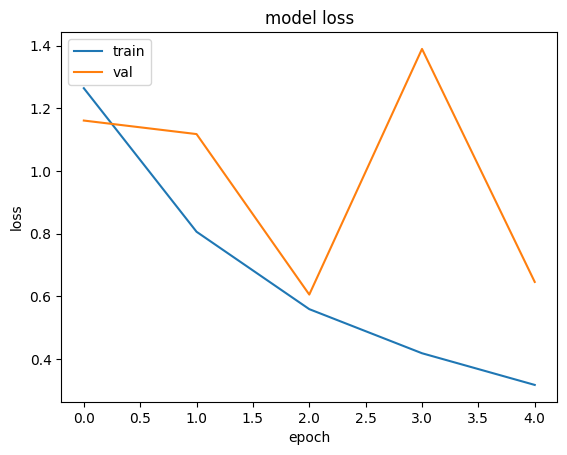

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2. d.
Performance analysis based on testing dataset (find precision, recall, F1-Score and accuracy) of the model and analysis the result.

In [ ]:
custom_objects = {'TFBertModel': TFBertModel}

best_model = load_model("nghuyong/ernie-2.0-base-en", custom_objects=custom_objects)

predict_prob = best_model.predict([test_inputs_ids, test_inputs_mask, test_inputs_token])
prediction = np.argmax(predict_prob, axis = 1)

94/94 [==============================] - 27s 256ms/step


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report

In [ ]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       851
           1       0.79      0.80      0.79       430
           2       0.77      0.62      0.69       254
           3       0.84      0.35      0.49       109
           4       0.78      0.67      0.72       343
           5       0.84      0.86      0.85      1013

    accuracy                           0.80      3000
   macro avg       0.80      0.70      0.73      3000
weighted avg       0.80      0.80      0.80      3000



In [ ]:
print(f"Precision: {precision_score(Y_test, prediction, average='macro')}")
print(f"Recall: {recall_score(Y_test, prediction,average='macro')}")
print(f"f1: {f1_score(Y_test, prediction,average='macro')}")
print(f"Accuracy: {accuracy_score(Y_test,prediction)}")

Precision: 0.8002402280921946
Recall: 0.7000298661414143
f1: 0.7303254966032905
Accuracy: 0.8016666666666666


- Precision: 0,8002402280921946.
Presisi adalah rasio pengamatan positif yang diprediksi dengan benar terhadap total prediksi positif.
Dalam kasus ini, sekitar 80,02% kasus yang diprediksi positif ternyata positif.
- Recall: 0,7000298661414143.
Recall adalah rasio observasi positif yang diprediksi dengan benar terhadap seluruh observasi di kelas sebenarnya.
Di sini, sekitar 70,00% kasus positif aktual diprediksi dengan tepat oleh model.
- F1: 0,7303254966032905.
F1 adalah rata-rata harmonik antara presisi dan perolehan. F1 memberikan keseimbangan antara presisi dan perolehan. Dalam hal ini skor F1 sekitar 73,03%.
- Accuracy: 0,8016666666666666.
Akurasi adalah rasio observasi yang diprediksi dengan benar terhadap total observasi.Model ini memiliki akurasi sekitar 80,17% pada kumpulan data.

Referensi : Powers, D. M. (2020). Evaluation: from precision, recall and F-measure to ROC, informedness, markedness and correlation. arXiv preprint arXiv:2010.16061. Diakses dari : https://arxiv.org/abs/2010.16061